## Energy Price Modeling - ARIMAX

In this notebook, we will construct an ARIMA model with exogenous variables (otherwise known as an ARIMAX model) in order to predict the price of energy.

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import datetime
import datetime as datetime
import os

import seaborn as sns
import warnings

In [163]:
energy_df = pd.read_csv('./Modeling_DataFrames/price_gen_demand.csv')
energy_df.set_index('date_and_time', inplace=True)

In [164]:
energy_df

,load_zone,zone_price,wind_mwh,solar_mwh,biomass_mwh,carbon_mwh,combined_cycle_mwh,internal_combustion_mwh,geothermal_mwh,hydro_mwh,nuclear_mwh,conventional_thermal_mwh,natural_gas_mwh,NES_demand_mwh,NES_forecasted_demand_mwh,NES_MAPE
date_and_time,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,MONTERREY,469.72,2046.9551,0.014,24.1485,1236.4395,15212.2632,295.2078,602.0889,1639.9140,1481.9633,1612.2789,1323.9454,3724.0,3947,5.988185
2019-01-01 01:00:00,MONTERREY,468.52,2008.7178,0.014,24.5787,1259.8450,14716.7802,290.7521,600.6413,1359.4183,1482.0395,1622.8851,1316.4896,3677.0,3845,4.568942
2019-01-01 02:00:00,MONTERREY,460.61,2053.5246,0.000,23.2666,1264.3421,14158.9726,283.5448,601.0346,1109.2743,1482.5726,1631.1217,1318.2459,3625.0,3756,3.613793
2019-01-01 03:00:00,MONTERREY,460.76,2080.1841,0.000,24.9682,1264.9099,13554.0873,278.6723,603.3866,918.1252,1481.9557,1689.4191,1317.6234,3587.0,3707,3.345414
2019-01-01 04:00:00,MONTERREY,447.46,2183.7016,0.000,23.5932,1256.3677,12898.8769,274.7940,603.0097,922.1471,1482.7002,1654.2472,1315.9542,3522.0,3623,2.867689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,MONTERREY,450.59,1699.0485,0.000,24.2125,1880.1356,18286.1982,248.0208,496.1574,4794.6894,1565.9424,2131.5933,1328.9278,4545.0,4437,2.376238
2022-12-31 20:00:00,MONTERREY,421.95,1504.0209,0.000,24.2535,1880.4144,18130.0572,256.1454,496.4124,3831.8063,1566.4951,1963.7167,1311.5874,4344.0,4248,2.209945
2022-12-31 21:00:00,MONTERREY,410.96,1513.9210,0.000,23.2470,1844.1023,17786.4980,255.6818,496.4954,2769.6718,1566.3799,1958.3510,1300.0403,4225.0,4108,2.769231


## Weather Data

In [165]:
weather_df = pd.DataFrame()

for record in os.listdir('./Weather/'):
    if record == '.DS_Store':
        pass
    else:
        file_df = pd.read_csv('./Weather/' + record)
        weather_df = weather_df.append(file_df) 
        
weather_df['date_and_time'] = pd.to_datetime(weather_df['dt_iso'].str[0:19], format='%Y-%m-%d %H:%M:%S')
weather_df['year'] = pd.to_datetime(weather_df['date_and_time']).dt.year
weather_df['month'] = pd.to_datetime(weather_df['date_and_time']).dt.month
weather_df['day'] = pd.to_datetime(weather_df['date_and_time']).dt.day
weather_df['hour'] = pd.to_datetime(weather_df['date_and_time']).dt.hour

weather_df = weather_df[['date_and_time', 'year', 'month', 'day', 'temp']].set_index('date_and_time')
energy_df.index = pd.to_datetime(energy_df.index)
edw_df = energy_df.join(weather_df, how='inner')

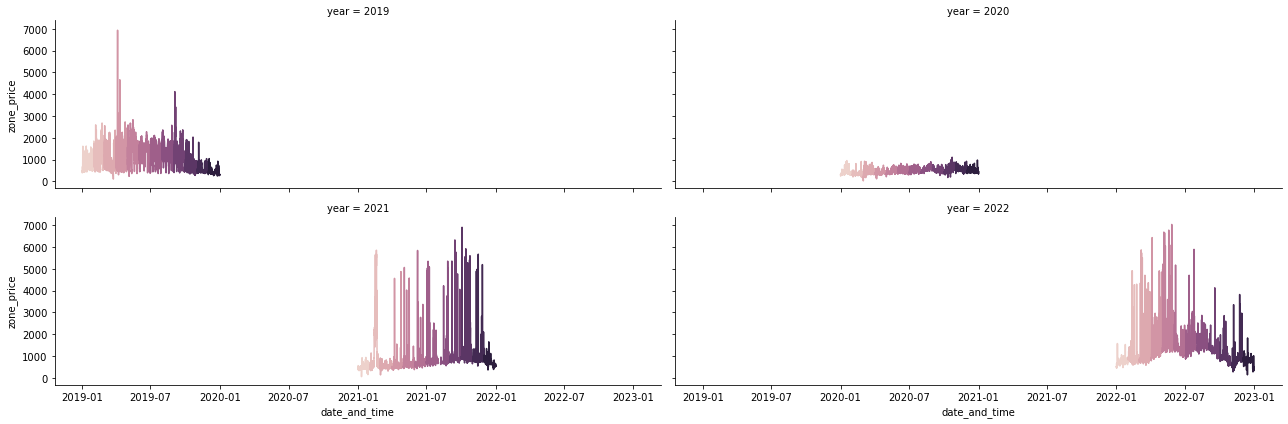

In [166]:
g = sns.FacetGrid(edw_df.reset_index(), col="year", col_wrap=2, height=3, aspect=3)
g.map(sns.lineplot, "date_and_time","zone_price", 'month')
plt.show()

Although we expected some seasonality, energy prices in 2020 seem to have broken whatever pattern is present in the rest of the data, which has more variable energy prices than in 2020.

## Decomposing the Data

Our data is hourly, so our period is 365 x 24 = 8760

In [167]:
# decompose Trips using "additive" and a period of 8760
decomposed_result = seasonal_decompose(edw_df[['zone_price']], model = "additive", period = 8760)

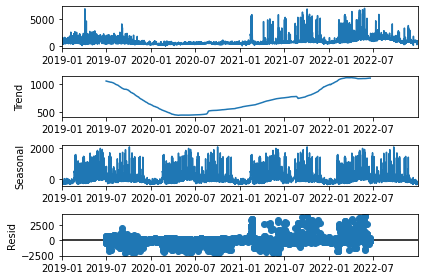

In [168]:
# plot decomposition
decomposed_result.plot();

In [169]:
edw_df[['zone_price']].describe()

,zone_price
count,35177.000000
mean,843.627783
std,552.081396
min,21.240000
25%,476.530000
50%,696.250000
75%,1012.780000
max,7035.530000


## Modeling - ARIMAX Model: Zone Price vs Demand & Temperature

Although we have several variables to choose from, I'm simply going to regress energy price against itself, the aggregate demand for energy in the northeast region of the country, as well as temperature.

In [170]:
dem_temp_df = edw_df[['zone_price', 'NES_demand_mwh', 'temp']]

In [171]:
X = dem_temp_df.drop(columns=['zone_price'])
y = dem_temp_df['zone_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, shuffle=False)

In [11]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 1, # we know how much to difference, so don't need to waste time searching for this,
#    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, # use seasonality!
    m = 1, # MUST tell which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=494072.564, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=493223.859, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=492916.111, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=494070.564, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=489613.493, Time=8.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=489613.653, Time=15.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=489613.679, Time=13.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=491963.100, Time=2.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=492692.721, Time=2.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=489615.523, Time=13.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=489611.494, Time=3.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=492914.111, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=493221.859, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=489611.654, Time=4.89 sec
 A

In [172]:
# Check orders
print("order: ", sarimax.order)
print("seasonal_order: ", sarimax.seasonal_order)

order:  (1, 1, 1)
seasonal_order:  (0, 0, 0, 0)


Now we use sarimax grid search to determine other components

In [21]:
def sarimax_grid_search(endog, exog, p_range = (0,2), q_range = (0,2), P_range = (0,2), Q_range = (0,2), d = 0, D = 0, S = 12, verbose = False):
    best_aic = 99 * (10 ** 16) # a very large number
    best_order = None
    best_seasonal_order = None
    best_model = None
    # Use nested for loop to iterate over values of p and q.
    for p in range(p_range[0], p_range[1] + 1): # adding 1 so range is inclusive
        for q in range(q_range[0], q_range[1] + 1): # adding 1 so range is inclusive
            for P in range(P_range[0], P_range[1] + 1): # adding 1 so range is inclusive
                for Q in range(Q_range[0], Q_range[1] + 1): # adding 1 so range is inclusiv
                    # Insert try and except statements.
                    try:
                        # Fitting an SARIMAX(p, d, q) & (P, D, Q, S) model.
                        if verbose:
                            print(f'Attempting to fit SARIMAX({p},{d},{q}) & ({P},{D},{Q},{S})')
                        order = (p,d,q) # values of p, d, q
                        seasonal_order = (P, D, Q, S)
                        # Instantiate SARIMA model.
                        sarima = SARIMAX(endog = endog.astype(float).dropna(), # endog = Y variable
                                         exog = exog.astype(float).dropna(), # INCLUDING EXOGENOUS VARIABLES
                                      order = order,
                                      seasonal_order = seasonal_order) 

                        # Fit SARIMAX model.
                        # model = sarima.fit()
                        # If getting Convergence Errors, try increasing maxiter and changing method
                        model = sarima.fit(maxiter = 200, method = "powell", disp = 0) # disp = 0 b/c of excessive output

                        if verbose:
                            print(f'The AIC for SARIMAX({p},{d},{q})  & ({P},{D},{Q},{S}) is: {model.aic}')

                        # Is my current model's AIC better than our best_aic?
                        if model.aic < best_aic:

                            # If so, let's overwrite best found so far
                            best_aic = model.aic
                            best_order = order
                            best_seasonal_order = seasonal_order
                            best_model = model

                    except Exception as e:
                        print(e)
                        pass

    return {
        "best_aic": best_aic, 
        "best_order" : best_order, 
        "best_seasonal_order" : best_seasonal_order, 
        "best_model": best_model
    }

In [25]:
# try out function on our data (with exog)
sarimax_gs_result = sarimax_grid_search(y, X, d = 1, D = 1, S = 7, verbose = True);

Attempting to fit SARIMAX(0,1,0) & (0,1,0,7)
The AIC for SARIMAX(0,1,0)  & (0,1,0,7) is: 518287.63915670494
Attempting to fit SARIMAX(0,1,0) & (0,1,1,7)
The AIC for SARIMAX(0,1,0)  & (0,1,1,7) is: 493930.00480943674
Attempting to fit SARIMAX(0,1,0) & (0,1,2,7)
The AIC for SARIMAX(0,1,0)  & (0,1,2,7) is: 493931.10573732055
Attempting to fit SARIMAX(0,1,0) & (1,1,0,7)
The AIC for SARIMAX(0,1,0)  & (1,1,0,7) is: 508288.5945929025
Attempting to fit SARIMAX(0,1,0) & (1,1,1,7)
The AIC for SARIMAX(0,1,0)  & (1,1,1,7) is: 493937.3375054906
Attempting to fit SARIMAX(0,1,0) & (1,1,2,7)
The AIC for SARIMAX(0,1,0)  & (1,1,2,7) is: 493932.02208354895
Attempting to fit SARIMAX(0,1,0) & (2,1,0,7)
The AIC for SARIMAX(0,1,0)  & (2,1,0,7) is: 504982.79472401866
Attempting to fit SARIMAX(0,1,0) & (2,1,1,7)
The AIC for SARIMAX(0,1,0)  & (2,1,1,7) is: 493931.79779232526
Attempting to fit SARIMAX(0,1,0) & (2,1,2,7)
The AIC for SARIMAX(0,1,0)  & (2,1,2,7) is: 493932.824954408
Attempting to fit SARIMAX(0,1,1)

The AIC for SARIMAX(2,1,2)  & (1,1,1,7) is: 489083.9905609889
Attempting to fit SARIMAX(2,1,2) & (1,1,2,7)
The AIC for SARIMAX(2,1,2)  & (1,1,2,7) is: 489070.3727114967
Attempting to fit SARIMAX(2,1,2) & (2,1,0,7)
The AIC for SARIMAX(2,1,2)  & (2,1,0,7) is: 498684.8496985627
Attempting to fit SARIMAX(2,1,2) & (2,1,1,7)
The AIC for SARIMAX(2,1,2)  & (2,1,1,7) is: 489066.5881668851
Attempting to fit SARIMAX(2,1,2) & (2,1,2,7)
The AIC for SARIMAX(2,1,2)  & (2,1,2,7) is: 489073.9699299456


In [26]:
sarimax_gs_result

{'best_aic': 489062.1962308595,
 'best_order': (1, 1, 1),
 'best_seasonal_order': (2, 1, 1, 7),
 'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f829fc0fd00>}

## Modeling

In [53]:
order = (1, 1, 1)
seasonal_order = (2, 1, 1, 7)

# instantiate
demand_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
#    freq = "D", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

fitted_demand_sarimax = demand_sarimax.fit() # stats model returns fitted model

In [68]:
print(fitted_demand_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        zone_price   No. Observations:                35177
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood             -247152.829
Date:                           Sun, 05 Feb 2023   AIC                         494321.658
Time:                                   20:58:58   BIC                         494389.398
Sample:                                        0   HQIC                        494343.230
                                         - 35177                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
NES_demand_mwh     0.0667      0.007      9.727      0.000       0.053       0.080
temp              11.6338      

## Model Predictions

In [110]:
starting_index = round(len(y) * 0.8)
starting_index

28142

In [112]:
start_date = y.index[starting_index]
start_date

Timestamp('2022-02-21 19:00:00')

In [113]:
demand_test_preds = fitted_demand_sarimax.predict(start=start_date, dynamic=False)

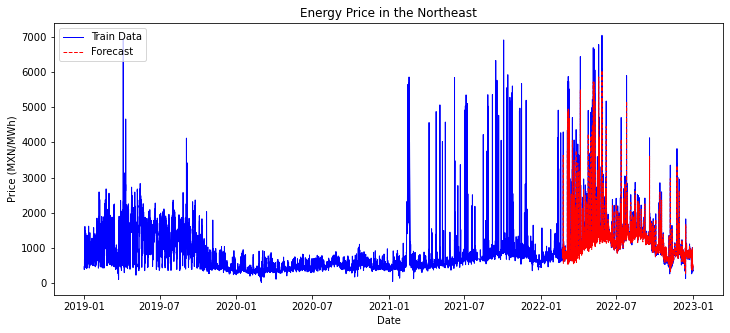

In [135]:
plt.figure(figsize=(12,5))
plt.title("Energy Price in the Northeast")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(demand_test_preds.index, demand_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Price (MXN/MWh)")

# legend
plt.legend(loc = "upper left");

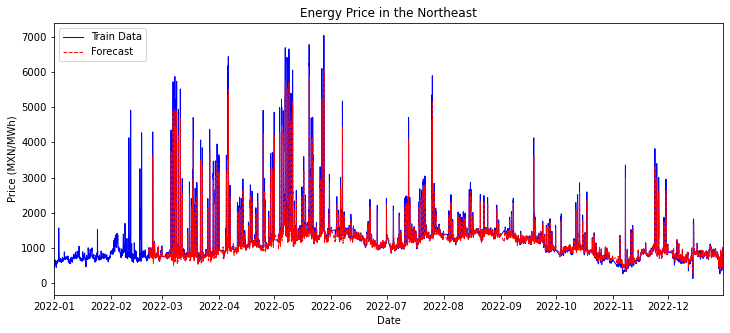

In [136]:
plt.figure(figsize=(12,5))
plt.title("Energy Price in the Northeast")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(demand_test_preds.index, demand_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Price (MXN/MWh)")

# legend
plt.legend(loc = "upper left");

plt.xlim([datetime.date(2022, 1, 1), datetime.date(2022, 12, 31)]);

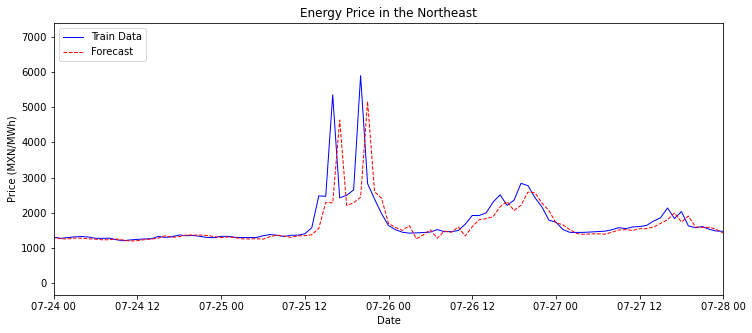

In [137]:
plt.figure(figsize=(12,5))
plt.title("Energy Price in the Northeast")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(demand_test_preds.index, demand_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Price (MXN/MWh)")

# legend
plt.legend(loc = "upper left");

plt.xlim([datetime.date(2022, 7, 24), datetime.date(2022,7, 28)]);

## Model Scoring

In [138]:
## R2 score
r2_score(y[start_date:], demand_test_preds)

0.6243890046135274

In [142]:
# RMSE
(mean_squared_error(y[start_date:], demand_test_preds)) ** 0.5

366.7540056292414

According this RMSE measure, when forecasting the price of energy, our model is off by about 367 MXN, give or take. 